In [86]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Image

# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Designer Filters

To show how to load, manipulate, and save parameters we'll design our own filters into a simple network that's only a single convolution layer. This net has two blobs, `data` for the input and `conv` for the convolution output and one parameter `conv` for the convolution filter weights and biases.

In [87]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_gpu()
net = caffe.Net('./dvia_fpga_dump.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))
blobs = net.blobs.keys()
for b in blobs:
    shape = net.blobs[b].data.shape
    print "blob {} shape {}".format(b, shape)

params = net.params.keys()
for p in params:
    shape = net.params[p][0].data.shape
    print "param {} shape {}".format(p, shape)
    shape = net.params[p][1].data.shape
    print "param {} shape {}".format(p, shape)
    
    

blobs ['data', 'conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'pool3', 'conv_last', 'fc_class', 'prob']
params ['conv1', 'conv2', 'conv3', 'conv_last', 'fc_class']
blob data shape (1, 3, 32, 32)
blob conv1 shape (1, 64, 28, 28)
blob pool1 shape (1, 64, 14, 14)
blob conv2 shape (1, 100, 12, 12)
blob pool2 shape (1, 100, 6, 6)
blob conv3 shape (1, 200, 4, 4)
blob pool3 shape (1, 200, 2, 2)
blob conv_last shape (1, 384, 2, 2)
blob fc_class shape (1, 4)
blob prob shape (1, 4)
param conv1 shape (64, 3, 5, 5)
param conv1 shape (64,)
param conv2 shape (100, 64, 3, 3)
param conv2 shape (100,)
param conv3 shape (200, 100, 3, 3)
param conv3 shape (200,)
param conv_last shape (384, 200, 1, 1)
param conv_last shape (384,)
param fc_class shape (4, 1536)
param fc_class shape (4,)


im new shape: (3, 32, 32)
None
im_input shape: (1, 3, 32, 32)
data blob shape: (1, 3, 32, 32)


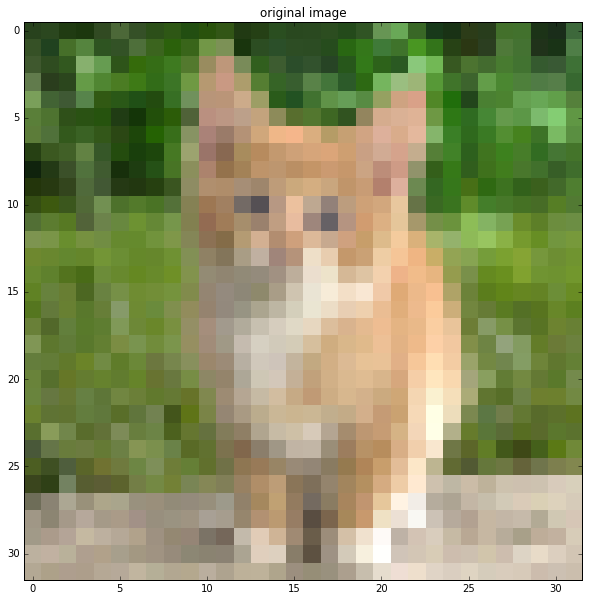

In [88]:
# Filter an example image.
from scipy import misc
caffe.set_mode_gpu()

# load image and prepare as a single input batch for Caffe
im = np.array(Image.open('../images/cat32x32.jpg'))
im2 = misc.imresize(im, (32,32), interp='bicubic')/256.0
imm = np.transpose(im2, (2, 0, 1))

print "im new shape: {}".format(imm.shape)
plt.title("original image")
plt.imshow(im)
#plt.axis('off')

print np.newaxis
im_input = imm[np.newaxis, :, :]
print "im_input shape: {}".format(im_input.shape)
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
print "data blob shape: {}".format(net.blobs['data'].data.shape)


The convolution weights are initialized from Gaussian noise while the biases are initialized to zero. These random filters give output somewhat like edge detections.

In [89]:
### This block prints the layer outputs to files
from sys import stdout
net.forward()
blobs = net.blobs.keys()
for b in blobs:
    shape = net.blobs[b].data.shape
    print "blob {} shape {}".format(b, shape)
    print "Create a file with name {}_output.h".format(b)
    ic = open("C_FILES/{}_output.h".format(b), 'w')
    print ic
    ic.write("float {}_output ".format(b))
    for s in range(len(shape)):
        ic.write("[{}]".format(shape[s]))
    ic.write(" = {\n")
    for m in range(0,shape[0]):
        for n in range(0,shape[1]):
            ic.write("{")
            par = net.blobs[b].data[m][n]
            if(len(shape) > 2):
                for r in range(0,shape[2]):
                    ic.write("{")
                    if(len(shape) > 3):
                        for c in range(0, shape[3]):
                            comma = "," if (c<shape[3]-1) else ""
                            ic.write("{:1.2f}{} ".format(par[r][c], comma))
                        comma = "," if (r<shape[2]-1) else ""
                        ic.write("}%s\n"%(comma))
            else: #if(len(shape) > 2)
                ic.write("{:1.2f}".format(par))
            comma = "," if (n<shape[1]-1) else ""
            ic.write("}%s\n"%(comma))
    ic.write("};")
    print "Done"
    ic.close()


blob data shape (1, 3, 32, 32)
Create a file with name data_output.h
<open file 'C_FILES/data_output.h', mode 'w' at 0x7f02f9831f60>
Done
blob conv1 shape (1, 64, 28, 28)
Create a file with name conv1_output.h
<open file 'C_FILES/conv1_output.h', mode 'w' at 0x7f02f993d6f0>
Done
blob pool1 shape (1, 64, 14, 14)
Create a file with name pool1_output.h
<open file 'C_FILES/pool1_output.h', mode 'w' at 0x7f02f9927f60>
Done
blob conv2 shape (1, 100, 12, 12)
Create a file with name conv2_output.h
<open file 'C_FILES/conv2_output.h', mode 'w' at 0x7f02f993d6f0>
Done
blob pool2 shape (1, 100, 6, 6)
Create a file with name pool2_output.h
<open file 'C_FILES/pool2_output.h', mode 'w' at 0x7f02f9927f60>
Done
blob conv3 shape (1, 200, 4, 4)
Create a file with name conv3_output.h
<open file 'C_FILES/conv3_output.h', mode 'w' at 0x7f02f993d6f0>
Done
blob pool3 shape (1, 200, 2, 2)
Create a file with name pool3_output.h
<open file 'C_FILES/pool3_output.h', mode 'w' at 0x7f02f9927f60>
Done
blob conv_la

In [90]:
## This block will print weights and bias to files
params = net.params.keys()

## Weights ================>
for p in params:
    shape = net.params[p][0].data.shape
    print "param {} shape {}".format(p, shape)
    print "Create a file with name {}_weights.h".format(p)
    ic = open("C_FILES/{}_weights.h".format(p), 'w')
    print ic
    ic.write("float {}_weights ".format(p))
    for s in range(len(shape)):
        ic.write("[{}]".format(shape[s]))
    ic.write(" = {\n")
    for m in range(0,shape[0]):
        ic.write("{")
        for n in range(0,shape[1]):
            ic.write("{")
            par = net.params[p][0].data[m][n]
            if(len(shape) > 2):
                for r in range(0,shape[2]):
                    ic.write("{")
                    if(len(shape) > 3):
                        for c in range(0, shape[3]):
                            comma = "," if (c<shape[3]-1) else ""
                            ic.write("{:1.2f}{} ".format(par[r][c], comma))
                        comma = "," if (r<shape[2]-1) else ""
                        ic.write("}%s\n"%(comma))
            else: #if(len(shape) > 2)
                ic.write("{:1.2f}".format(par))
            comma = "," if (n<shape[1]-1) else ""
            ic.write("}%s\n"%(comma))
        comma = "," if (m<shape[0]-1) else ""
        ic.write("}%s\n"%(comma))
    ic.write("};")
    print "Done"
    ic.close()

## Bias =======================================>
for p in params:
    shape = net.params[p][1].data.shape
    print "param {} shape {}".format(p, shape)
    print "Create a file with name {}_bias.h".format(p)
    ic = open("C_FILES/{}_bias.h".format(p), 'w')
    print ic
    ic.write("float {}_bias ".format(p))
    for s in range(len(shape)):
        ic.write("[{}]".format(shape[s]))
    ic.write(" = {\n")
    for m in range(0,shape[0]):
        if(len(shape) > 1):
            for n in range(0,shape[1]):
                ic.write("{")
                par = net.params[p][1].data[m][n]
                if(len(shape) > 2):
                    for r in range(0,shape[2]):
                        ic.write("{")
                        if(len(shape) > 3):
                            for c in range(0, shape[3]):
                                comma = "," if (c<shape[3]-1) else ""
                                ic.write("{:1.2f}{} ".format(par[r][c], comma))
                            comma = "," if (r<shape[2]-1) else ""
                            ic.write("}%s\n"%(comma))
                else: #if(len(shape) > 2)
                    ic.write("{:1.2f}".format(par))
                comma = "," if (n<shape[1]-1) else ""
                ic.write("}%s\n"%(comma))
        else: #if(len(shape) > 1)
            par = net.params[p][1].data[m]
            comma = "," if (m<shape[0]-1) else ""
            ic.write("{:1.2f}{} ".format(par, comma))
    ic.write("};")
    print "Done"
    ic.close()    

param conv1 shape (64, 3, 5, 5)
Create a file with name conv1_weights.h
<open file 'C_FILES/conv1_weights.h', mode 'w' at 0x7f02f9927f60>
Done
param conv2 shape (100, 64, 3, 3)
Create a file with name conv2_weights.h
<open file 'C_FILES/conv2_weights.h', mode 'w' at 0x7f02f993d6f0>
Done
param conv3 shape (200, 100, 3, 3)
Create a file with name conv3_weights.h
<open file 'C_FILES/conv3_weights.h', mode 'w' at 0x7f02f9927f60>
Done
param conv_last shape (384, 200, 1, 1)
Create a file with name conv_last_weights.h
<open file 'C_FILES/conv_last_weights.h', mode 'w' at 0x7f02f993d6f0>
Done
param fc_class shape (4, 1536)
Create a file with name fc_class_weights.h
<open file 'C_FILES/fc_class_weights.h', mode 'w' at 0x7f02f9927f60>
Done
param conv1 shape (64,)
Create a file with name conv1_bias.h
<open file 'C_FILES/conv1_bias.h', mode 'w' at 0x7f02f993d6f0>
Done
param conv2 shape (100,)
Create a file with name conv2_bias.h
<open file 'C_FILES/conv2_bias.h', mode 'w' at 0x7f02f9927f60>
Done
p

*A thank you to Rowland Depp for first suggesting this trick.*